# Import Libraries

In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D,MaxPooling2D, Activation, Dropout, BatchNormalization
from tensorflow.python.keras.optimizers import *
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from math import *

In [26]:
tf.__version__

'2.5.0'

# Load the Train,Test, and Validation Data as grayscale

## Image folder path to work with ImageDataGenerator

In [2]:
# Image folder path to work with ImageDataGenerator
path = "C:\\DataScience\\ADC\\ClothNew\\"
train_data_path = path+"train"
test_data_path = path+"test"
valid_data_path = path+"valid"

## Check the images

## Function: Color to Grayscale

In [3]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    #image = tf.image.grayscale_to_rgb(image)
    return image

In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True
        
callbacks = myCallback()

# Use ImageDataGenerator for preprocessing the data

## Define Image and Batch size

In [5]:
img_rows = 256
img_cols = 256
batch_size = 64

## Preprocessing Data Generator for Training data
1. Image rescaling.
2. RGB to grayscale
3. Data augmentation parameters
4. Using fillmode as nearest. Can try with Wrap, Reflect, or default to see results.

In [6]:
train_datagen = ImageDataGenerator(
                preprocessing_function=to_grayscale
                )

train_generator = train_datagen.flow_from_directory(train_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    #color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical', shuffle=True)

valid_datagen = ImageDataGenerator(rescale=1/.255, preprocessing_function=to_grayscale)
valid_generator = valid_datagen.flow_from_directory(test_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    #color_mode='grayscale',
                                                    class_mode='categorical', shuffle=True)

test_datagen = ImageDataGenerator(rescale=1/.255, preprocessing_function=to_grayscale)
test_generator = test_datagen.flow_from_directory(valid_data_path,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    #color_mode='grayscale',
                                                    class_mode='categorical', shuffle=False)

Found 9216 images belonging to 12 classes.
Found 446 images belonging to 12 classes.
Found 148 images belonging to 12 classes.


## Verify the images/labels by ImageDatagenerator

In [7]:
# Function for plots images with labels within jupyter notebook
def plots(ims, figsize=(40,40), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1

    for i in range(len(ims)):
        sp = f.add_subplot(cols, rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Number of classes:  12


C:\Users\Admin\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


{'Addidas': 0, 'Amoco': 1, 'Batman': 2, 'Beretta': 3, "Birki's": 4, 'Birmingham': 5, 'Brioni': 6, 'Brother': 7, 'Buffalo': 8, 'Burberry': 9, 'Ceceba': 10, "Copeland's": 11}


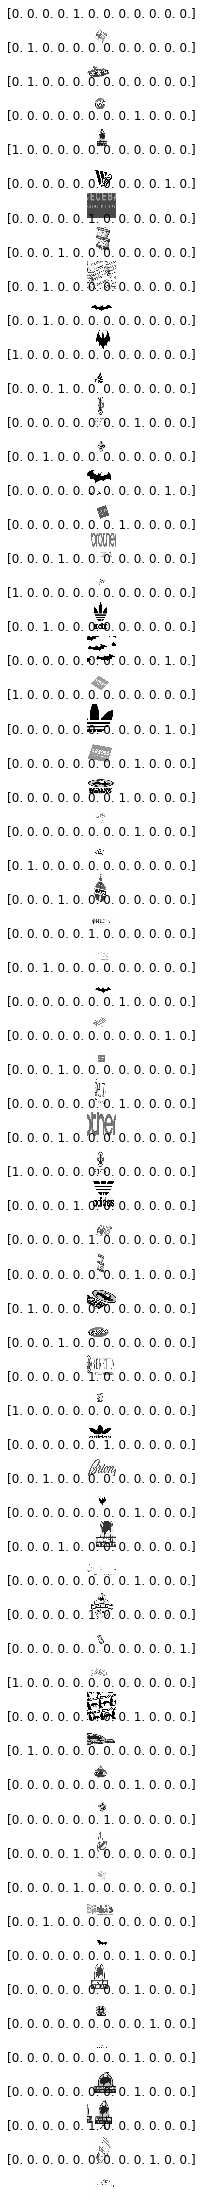

In [8]:
imgs, labels = next(train_generator)
num_classes = train_generator.num_classes
print("Number of classes: ", num_classes)

#Images are shown in the output
plots(imgs, titles=labels)
#Images Classes with index
print(train_generator.class_indices)


# Build a Model

In [9]:
#Model Creation / Sequential
model = Sequential([Conv2D(16, (3, 3), padding ='same',activation='relu',input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),
                    Dropout(0.3),
                    Conv2D(32, (3, 3), padding ='same',activation='relu',input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),  
                    Dropout(0.4),
                    Conv2D(64, (3, 3), padding ='same',activation='relu',input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),  
                    Dropout(0.5),
                    Conv2D(128, (3, 3), padding ='same',activation='relu',input_shape=(img_rows, img_cols, 3)),
                    MaxPooling2D(),  
                    Flatten(), 
                    Dense(512, activation = 'relu'),
                    Dense(num_classes, activation='softmax')
                   ])


In [10]:
#Get summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

# Compile the Model

In [11]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Calculate the effective number of Epochs for training the model


In [12]:
number_of_epochs = int((train_generator.n)/batch_size)

print (number_of_epochs)
num_validation_steps = int(ceil((valid_generator.n)/batch_size))
print (num_validation_steps)

144
7


# Train the Model

In [13]:
#Train the model
history = model.fit_generator(train_generator, 
                              steps_per_epoch=number_of_epochs, 
                              validation_data=valid_generator, 
                              validation_steps=num_validation_steps, 
                              epochs=50, 
                              callbacks=[callbacks])


C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
144/144 [==============================] - 338s 2s/step - loss: 504.9328 - accuracy: 0.1250 - val_loss: 2.4648 - val_accuracy: 0.0852
Epoch 2/50
144/144 [==============================] - 316s 2s/step - loss: 2.2451 - accuracy: 0.2207 - val_loss: 3.7633 - val_accuracy: 0.2130
Epoch 3/50
144/144 [==============================] - 317s 2s/step - loss: 1.9320 - accuracy: 0.3298 - val_loss: 5.3257 - val_accuracy: 0.2556
Epoch 4/50
144/144 [==============================] - 325s 2s/step - loss: 1.6764 - accuracy: 0.4177 - val_loss: 7.3650 - val_accuracy: 0.2735
Epoch 5/50
144/144 [==============================] - 318s 2s/step - loss: 1.4784 - accuracy: 0.4756 - val_loss: 10.2401 - val_accuracy: 0.2825
Epoch 6/50
144/144 [==============================] - 320s 2s/step - loss: 1.3577 - accuracy: 0.5019 - val_loss: 12.1170 - val_accuracy: 0.2937
Epoch 7/50
144/144 [==============================] - 326s 2s/step - loss: 1.2757 - accuracy: 0.5399 - val_loss: 16.2701 - val_accuracy: 0

# List the Performances 

## Accuracy Score

In [20]:
#Get the accuracy score
test_score = model.evaluate_generator(test_generator, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 55.41%
[INFO] Loss:  57.702796936035156


Text(0.5, 1.0, 'Accuracy Curves')

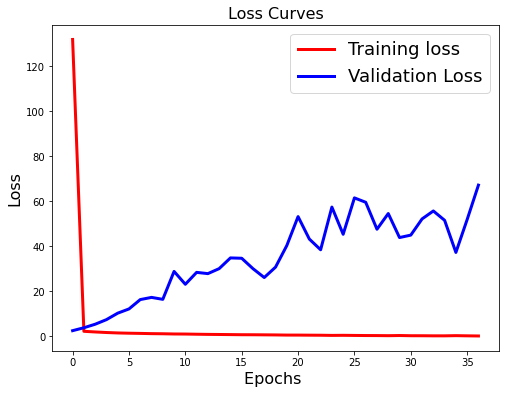

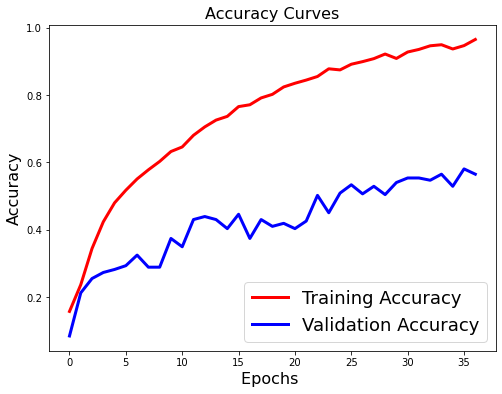

In [21]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


## Confusion Matrix

In [22]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [23]:
#Print the Target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
print(target_names)

['Addidas', 'Amoco', 'Batman', 'Beretta', "Birki's", 'Birmingham', 'Brioni', 'Brother', 'Buffalo', 'Burberry', 'Ceceba', "Copeland's"]


C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Normalized confusion matrix


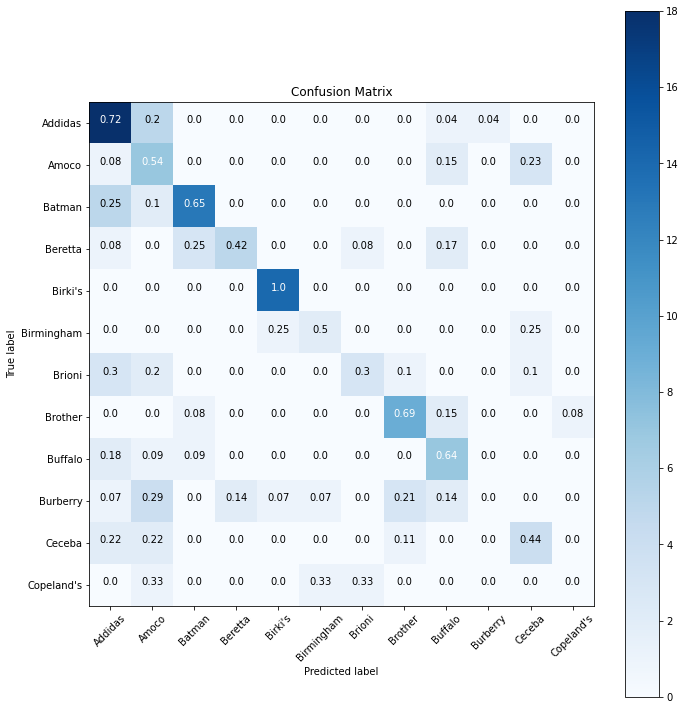

In [24]:
#Confution Matrix 
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

## Classification Report

In [25]:
#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     Addidas       0.55      0.72      0.62        25
       Amoco       0.29      0.54      0.38        13
      Batman       0.72      0.65      0.68        20
     Beretta       0.71      0.42      0.53        12
     Birki's       0.88      1.00      0.93        14
  Birmingham       0.50      0.50      0.50         4
      Brioni       0.60      0.30      0.40        10
     Brother       0.64      0.69      0.67        13
     Buffalo       0.44      0.64      0.52        11
    Burberry       0.00      0.00      0.00        14
      Ceceba       0.44      0.44      0.44         9
  Copeland's       0.00      0.00      0.00         3

    accuracy                           0.55       148
   macro avg       0.48      0.49      0.47       148
weighted avg       0.53      0.55      0.53       148



# End of the Code